# Setup

## Imports

In [17]:
import pandas as pd
import chardet
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [18]:
def import_titles():
    df = pd.read_csv('movie_titles.txt', 
                     encoding="ISO-8859-1", 
                     usecols=[0, 1, 2])
    return df
    
def import_ratings(n):
    df = pd.read_csv('netflix_ratings.txt', 
                     encoding="ascii", 
                     sep=' ',
                     header=None,
                     names=["M_ID", "M_Year", "U_ID", "U_Rating", "U_Date"])
    df = df[df["M_ID"].between(1, n)]
    return df

In [19]:
titles = import_titles()
ratings = import_ratings(500)

In [20]:
print("Shape of titles:",titles.shape)
print("Columns:",titles.columns,"\n")

print("Shape of ratings:",ratings.shape)
print("Columns:",ratings.columns)

Shape of titles: (17770, 3)
Columns: Index(['Index', ' Year', ' Title'], dtype='object') 

Shape of ratings: (2798704, 5)
Columns: Index(['M_ID', 'M_Year', 'U_ID', 'U_Rating', 'U_Date'], dtype='object')


## Dataframe Merger

In [21]:
def prepare_PCA_df(n):

    # Create PCA_df directly using pivot
    df = pd.pivot(ratings, values='U_Rating', index='M_ID', columns='U_ID')

    # Drop columns with less than a n of non-NaN values
    df = df.dropna(axis=1, thresh=len(df) / n).fillna(0)

    # Fill NaN values with 0
    df.fillna(0, inplace=True)

    return df

### Create Dataframe for PCA

In [22]:
pre_PCA = prepare_PCA_df(4) # Create df and remove a quarter of NaN-values

## PCA Function

In [23]:
def perform_pca(data, variance_threshold=0.95):
    pca = PCA()
    pca.fit(data)

    # Determine the number of components that explain the desired variance threshold
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
    n_components = np.argmax(cumulative_variance_ratio >= variance_threshold) + 1

    # Perform PCA again with the selected number of components
    pca = PCA(n_components=n_components)
    pca_values = pca.fit_transform(data)

    # Create a new DataFrame with PCA values
    pca_df = pd.DataFrame(data=pca_values, columns=[f'PCA{i+1}' for i in range(n_components)])

    return cumulative_variance_ratio, pca_df

## Plotting Function

In [24]:
def plot_scree_plot(cumulative_variance_ratio, label):
    
    component_number = np.arange(1, len(cumulative_variance_ratio) + 1)
    
    plt.plot(component_number, cumulative_variance_ratio, 'o-', linewidth=2, label = label)
    plt.xlabel('Component Number')
    plt.ylabel('Cumulative Variance Ratio')
    plt.grid(True)
    
    # Add labels, title, and legend
    plt.xlabel('Component number')
    plt.ylabel('Cumulative Variance Ratio')
    plt.grid(True)
    plt.legend()

### Create Baseline PCA

In [8]:
joint_cumulative_variance_ratio, joint_pca_df = perform_pca(pre_PCA)

## Create Uncorrelated PCA Dataframes
Dataframes split in half.

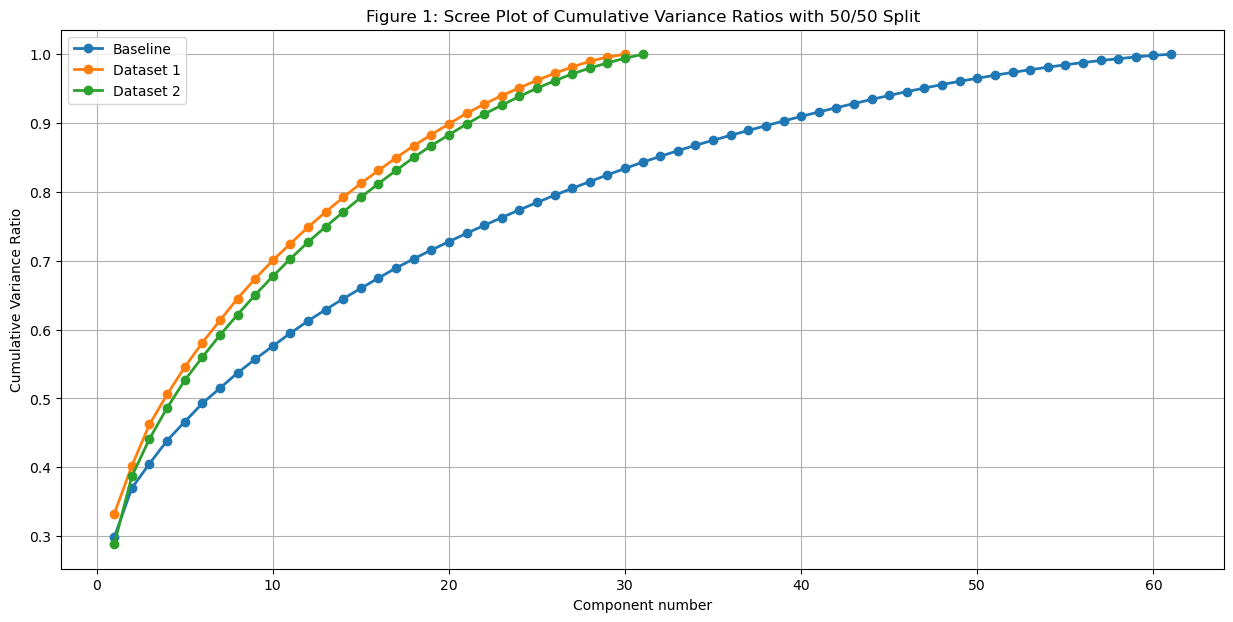

In [16]:
# Calculate the midpoint for column splitting
midpoint = len(pre_PCA.columns) // 2

# Split the dataframe into two halves
df_1 = pre_PCA.iloc[:, :midpoint]  # First half of columns
df_2 = pre_PCA.iloc[:, midpoint:]  # Second half of columns

# Calculate respective PCAs for each dataframe
cvr1, pca_1 = perform_pca(df_1)
cvr2, pca_2 = perform_pca(df_2)

# Plot graphs
plt.figure(figsize=(15, 7))
plot_scree_plot(joint_cumulative_variance_ratio, "Baseline")
plot_scree_plot(cvr1, "Dataset 1")
plot_scree_plot(cvr2, "Dataset 2")

plt.title('Figure 1: Scree Plot of Cumulative Variance Ratios with 50/50 Split')
plt.show()

## Correlated by 40% similar columns

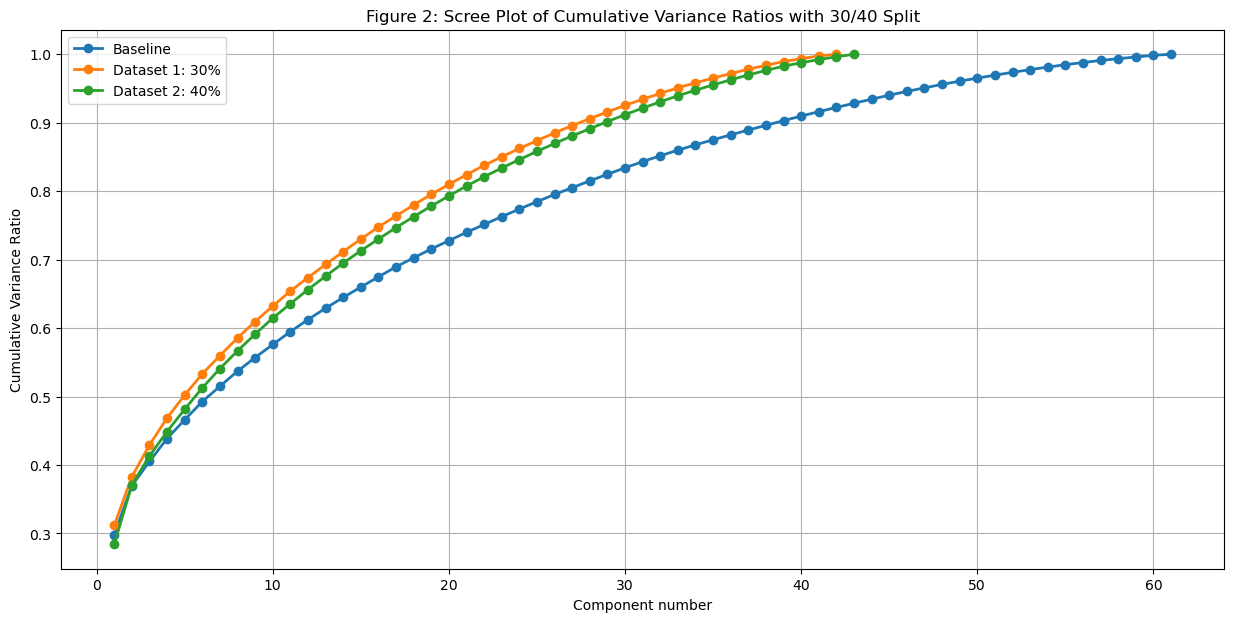

In [25]:
# Calculate the column splitting points
nr_columns = pre_PCA.shape[1]
splitpoint1 = int(nr_columns * 0.3 + nr_columns * 0.4)
splitpoint2 = int(nr_columns * 0.3)

# Split the dataframe into two halves
corr3040_1_df = pre_PCA.iloc[:, :splitpoint1]
corr3040_2_df = pre_PCA.iloc[:, splitpoint2:]

# Calculate respective PCAs for each dataframe
corr3040_pca_1_var_ratio, corr3040_pca_1 = perform_pca(corr3040_1_df)
corr3040_pca_2_var_ratio, corr3040_pca_2 = perform_pca(corr3040_2_df)

# Plot graphs
plt.figure(figsize=(15, 7))
plot_scree_plot(joint_cumulative_variance_ratio, "Baseline")
plot_scree_plot(corr3040_pca_1_var_ratio, "Dataset 1: 30%")
plot_scree_plot(corr3040_pca_2_var_ratio, "Dataset 2: 40%")
plt.title('Figure 2: Scree Plot of Cumulative Variance Ratios with 30/40 Split')
plt.show()

## Correlated by Random Choice

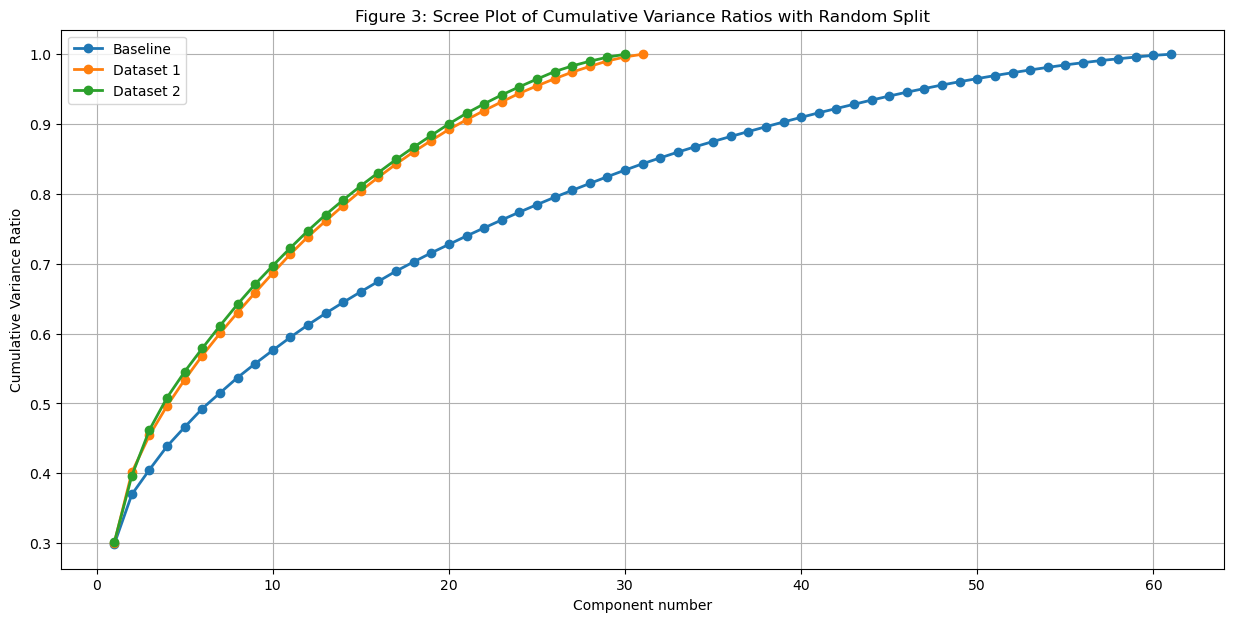

In [27]:
# Choose random columns
random_columns1 = np.random.choice(pre_PCA.columns, size=31, replace=False)
random1_df = pre_PCA[random_columns1]
random_columns2 = np.random.choice(pre_PCA.columns, size=30, replace=False)
random2_df = pre_PCA[random_columns2]

# Calculate respective PCAs for each dataframe
random_variance1, random_pca_1 = perform_pca(random1_df)
random_variance2, random_pca_2 = perform_pca(random2_df)

# Plot graphs
plt.figure(figsize=(15, 7))
plot_scree_plot(joint_cumulative_variance_ratio, "Baseline")
plot_scree_plot(random_variance1, "Dataset 1")
plot_scree_plot(random_variance2, "Dataset 2")
plt.title('Figure 3: Scree Plot of Cumulative Variance Ratios with Random Split')
plt.show()